In [34]:
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa.display
import os
from IPython.display import Audio
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc


# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [35]:
paths = []
labels = []
genders = []

# Use os.walk to walk through the directory structure
for dirname, _, filenames in os.walk(r'data'):
    for filename in filenames:
        if filename == '.DS_Store':
            continue  # Skip this file
        # Construct the full file path
        full_path = os.path.join(dirname, filename)
        paths.append(full_path)
        
        # Extract label and gender from the directory name
        # Assumes the structure is data/label_gender/filename
        folder_name = os.path.basename(dirname)
        label_gender = folder_name.split('_')
        if len(label_gender) == 2:  # Ensure the folder name is in the expected format
            label, gender = label_gender
        else:
            label, gender = folder_name, 'unknown'  # Default or error handling

        labels.append(label.lower())
        genders.append(gender.lower())

# Create a DataFrame with the collected data
df = pd.DataFrame({
    'speech': paths,
    'label': labels,
    'gender': genders
})

# Display the first few rows of the DataFrame to verify
print(df.head())


                                         speech  label  gender
0   data\Recordings\Angry_Female\anger_xn_1.wav  angry  female
1  data\Recordings\Angry_Female\anger_xn_10.wav  angry  female
2  data\Recordings\Angry_Female\anger_xn_11.wav  angry  female
3  data\Recordings\Angry_Female\anger_xn_12.wav  angry  female
4  data\Recordings\Angry_Female\anger_xn_13.wav  angry  female


In [36]:
# merge label and gender column into a single column
df['label'] = df['label'] + '_' + df['gender']

In [37]:
print(df.head())

                                         speech         label  gender
0   data\Recordings\Angry_Female\anger_xn_1.wav  angry_female  female
1  data\Recordings\Angry_Female\anger_xn_10.wav  angry_female  female
2  data\Recordings\Angry_Female\anger_xn_11.wav  angry_female  female
3  data\Recordings\Angry_Female\anger_xn_12.wav  angry_female  female
4  data\Recordings\Angry_Female\anger_xn_13.wav  angry_female  female


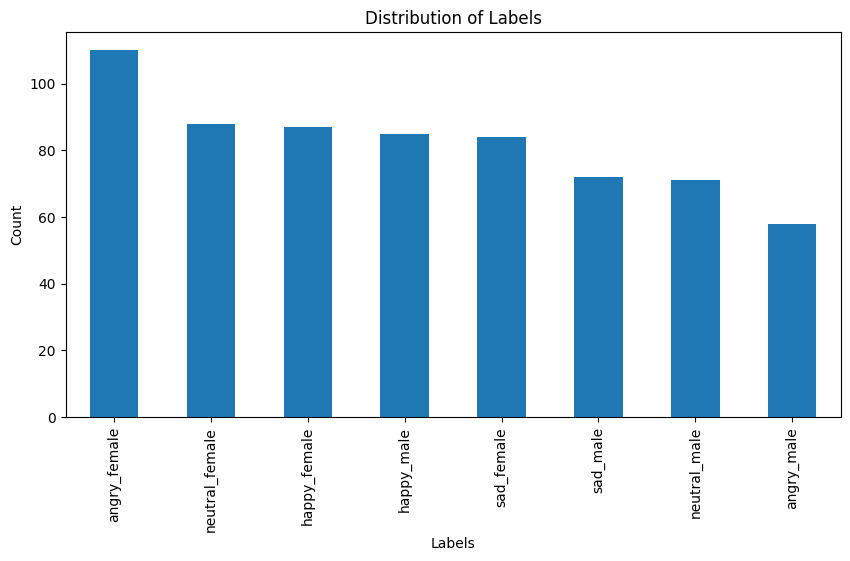

In [38]:
# plot the distribution of labels
plt.figure(figsize=(10, 5))
df['label'].value_counts().plot(kind='bar')
plt.title('Distribution of Labels')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

In [39]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=sr, color="blue")
    plt.show()
    
def spectogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

def extract_mfcc(filename):
    y, sr = librosa.load(filename, duration=3, offset=0.5)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
    return mfcc

def processData(df):
    X_mfcc = df['speech'].apply(lambda x: extract_mfcc(x))
    print(X_mfcc.head())
    X = [x for x in X_mfcc]
    X = np.array(X)
    X = np.expand_dims(X, -1)
    print(X.shape)

    enc = OneHotEncoder()
    y = enc.fit_transform(df[['label']])
    y = y.toarray()
    print(y.shape)
    # Include the speech column in the output
    speech = df['speech'].values
    
    return X, y, enc, speech


In [40]:
X, y, enc, speech = processData(df)

0    [-494.27545, 134.56302, -25.692623, 44.874004,...
1    [-489.2374, 95.24146, -6.124708, 45.02178, -1....
2    [-520.5528, 101.38984, -10.185469, 41.562035, ...
3    [-490.04434, 127.46854, -25.104696, 38.669415,...
4    [-475.49997, 120.51346, -31.929777, 47.917557,...
Name: speech, dtype: object
(655, 40, 1)
(655, 8)


In [41]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import tensorflow as tf
tf.random.set_seed(1)

model = Sequential([
    LSTM(256, return_sequences=False, input_shape=(40,1)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(8, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 256)            │       264,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 305,864 (1.17 MB)

 Trainable params: 305,864 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
from sklearn.model_selection import train_test_split

# Separate the test data
x_1, x_test, y_1, y_test, speech_1, speech_test = train_test_split(X, y, df['speech'].values, test_size=0.10, shuffle=True)

# Split the remaining data to train and validation
x_train, x_val, y_train, y_val, speech_train, speech_val = train_test_split(x_1, y_1, speech_1, test_size=0.15, shuffle=True)

# Training the Keras model
history = model.fit(x=x_train, y=y_train, batch_size=64, epochs=50, validation_data=(x_val, y_val))


Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.1564 - loss: 2.0674 - val_accuracy: 0.3371 - val_loss: 1.9299
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.3322 - loss: 1.8937 - val_accuracy: 0.3483 - val_loss: 1.7000
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.3174 - loss: 1.7829 - val_accuracy: 0.3596 - val_loss: 1.5416
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.3376 - loss: 1.6088 - val_accuracy: 0.4045 - val_loss: 1.4556
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.3914 - loss: 1.5383 - val_accuracy: 0.4494 - val_loss: 1.3321
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.4571 - loss: 1.4614 - val_accuracy: 0.4944 - val_loss: 1.2523
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.5365 - loss: 1.2654 - val_accuracy: 0.5506 - val_loss: 1.1008
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.5670 - loss: 1.1611 - val_accuracy: 0.5281 - val_loss: 1.2192


In [43]:
model.evaluate(x=x_test, y=y_test)
predictions = model.predict(x_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6341 - loss: 1.4337
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001E747C220C0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


In [70]:
# Inverse transform predictions and actual labels
y_pred = enc.inverse_transform(predictions)
y_test_transform = enc.inverse_transform(y_test)

# Create a DataFrame to store results including the speech column
result = pd.DataFrame(columns=['Speech', 'Predicted Labels', 'Actual Labels'])
result['Speech'] = speech_test
result['Predicted Labels'] = y_pred.flatten()
result['Actual Labels'] = y_test_transform.flatten()

# Print the length of the result DataFrame
print(len(result))


66


In [71]:
result

,Speech,Predicted Labels,Actual Labels
0,data\Recordings\Sad_Male\ml_sad-19.wav,angry_male,sad_male
1,data\Recordings\Happy_Female\happy_xn_1.wav,happy_female,happy_female
2,data\Recordings\Neutral_Female\neutral_xn_4.wav,neutral_female,neutral_female
3,data\Recordings\Happy_Female\happy_xn_21.wav,neutral_female,happy_female
4,data\Recordings\Happy_Male\ew_happy-17.wav,happy_male,happy_male
...,...,...,...
61,data\Recordings\Sad_Female\sad_xn_12.wav,sad_female,sad_female
62,data\Recordings\Sad_Female\ws_sad_14.wav,sad_female,sad_female
63,data\Recordings\Sad_Male\ew_sad-2.wav,sad_male,sad_male
64,data\Recordings\Happy_Female\ws_happy_26.wav,happy_female,happy_female


In [72]:
# check result accuracy for gender
# extract gender from Predicted Labels and Actual Labels
result['Predict Gender'] = result['Predicted Labels'].apply(lambda x: x.split('_')[1])
result['Actual Gender'] = result['Actual Labels'].apply(lambda x: x.split('_')[1])

# check accuracy for predict gender
accuracy = (result['Predict Gender'] == result['Actual Gender']).mean()
accuracy

0.9545454545454546

In [73]:
predict_gender = result['Predict Gender'].tolist()
actual_gender = result['Actual Gender'].tolist()

# Calculate accuracy
accuracy = accuracy_score(actual_gender, predict_gender)
print(f"Accuracy of Gender Prediction: {accuracy*100:.2f}%")

Accuracy of Gender Prediction: 95.45%


In [74]:
result

,Speech,Predicted Labels,Actual Labels,Predict Gender,Actual Gender
0,data\Recordings\Sad_Male\ml_sad-19.wav,angry_male,sad_male,male,male
1,data\Recordings\Happy_Female\happy_xn_1.wav,happy_female,happy_female,female,female
2,data\Recordings\Neutral_Female\neutral_xn_4.wav,neutral_female,neutral_female,female,female
3,data\Recordings\Happy_Female\happy_xn_21.wav,neutral_female,happy_female,female,female
4,data\Recordings\Happy_Male\ew_happy-17.wav,happy_male,happy_male,male,male
...,...,...,...,...,...
61,data\Recordings\Sad_Female\sad_xn_12.wav,sad_female,sad_female,female,female
62,data\Recordings\Sad_Female\ws_sad_14.wav,sad_female,sad_female,female,female
63,data\Recordings\Sad_Male\ew_sad-2.wav,sad_male,sad_male,male,male
64,data\Recordings\Happy_Female\ws_happy_26.wav,happy_female,happy_female,female,female


In [75]:
# count how many columns of gender are not matched
result[(result['Predict Gender'] != result['Actual Gender'])]

,Speech,Predicted Labels,Actual Labels,Predict Gender,Actual Gender
13,data\Recordings\Happy_Male\happy_xnm_34.wav,neutral_female,happy_male,female,male
15,data\Recordings\Angry_Male\ew_angry-11.wav,sad_female,angry_male,female,male
17,data\Recordings\Angry_Female\anger_xn_10.wav,neutral_male,angry_female,male,female


In [78]:
# Check result accuracy for emotion
# Extract emotion from Predicted Labels and Actual Labels
result['Predict Emotion'] = result['Predicted Labels'].apply(lambda x: x.split('_')[0])
result['Actual Emotion'] = result['Actual Labels'].apply(lambda x: x.split('_')[0])
result[(result['Predict Emotion'] != result['Actual Emotion'])]

,Speech,Predicted Labels,Actual Labels,Predict Gender,Actual Gender,Predict Emotion,Actual Emotion
0,data\Recordings\Sad_Male\ml_sad-19.wav,angry_male,sad_male,male,male,angry,sad
3,data\Recordings\Happy_Female\happy_xn_21.wav,neutral_female,happy_female,female,female,neutral,happy
6,data\Recordings\Happy_Female\jt_happy_22.wav,angry_female,happy_female,female,female,angry,happy
9,data\Recordings\Angry_Male\ew_angry-10.wav,happy_male,angry_male,male,male,happy,angry
10,data\Recordings\Angry_Female\anger_xn_41.wav,neutral_female,angry_female,female,female,neutral,angry
11,data\Recordings\Sad_Male\ew_sad-6.wav,angry_male,sad_male,male,male,angry,sad
13,data\Recordings\Happy_Male\happy_xnm_34.wav,neutral_female,happy_male,female,male,neutral,happy
15,data\Recordings\Angry_Male\ew_angry-11.wav,sad_female,angry_male,female,male,sad,angry
17,data\Recordings\Angry_Female\anger_xn_10.wav,neutral_male,angry_female,male,female,neutral,angry
23,data\Recordings\Sad_Female\jt_sadness_15.wav,angry_female,sad_female,female,female,angry,sad


----- F1 -----
0.6339092924619241
----- AUC ROC -----
0.9372066556640322
----- AUC ROC Curve -----


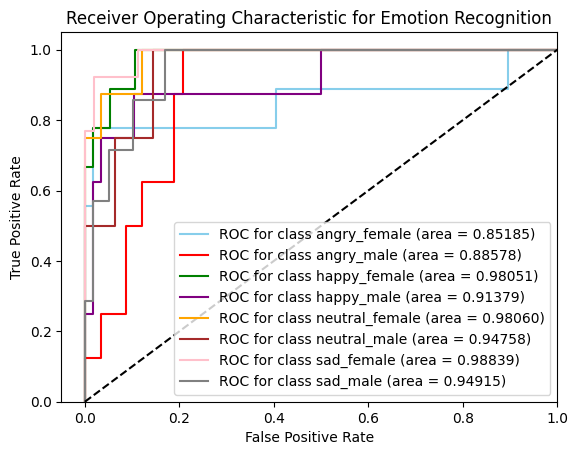

----- Confusion Matrix -----


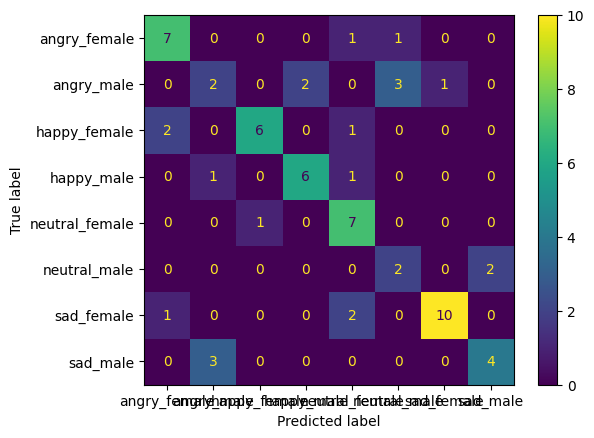

----- Classification Report -----
                precision    recall  f1-score   support

  angry_female       0.70      0.78      0.74         9
    angry_male       0.33      0.25      0.29         8
  happy_female       0.86      0.67      0.75         9
    happy_male       0.75      0.75      0.75         8
neutral_female       0.58      0.88      0.70         8
  neutral_male       0.33      0.50      0.40         4
    sad_female       0.91      0.77      0.83        13
      sad_male       0.67      0.57      0.62         7

      accuracy                           0.67        66
     macro avg       0.64      0.65      0.63        66
  weighted avg       0.68      0.67      0.67        66



In [61]:
from sklearn.metrics import (
    confusion_matrix, 
    ConfusionMatrixDisplay, 
    classification_report, 
    roc_curve, 
    auc,
    roc_auc_score,
    f1_score
)

print("----- F1 -----")
print(f1_score(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1), average="macro"))

print("----- AUC ROC -----")
print(roc_auc_score(y_test, predictions, multi_class="ovr", labels=list(enc.categories_[0])))

print("----- AUC ROC Curve -----")
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(8):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = ['skyblue', 'red', 'green', 'purple', 'orange', 'brown', 'pink', 'gray']
for i, color in zip(range(8), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1.5,
             label=f'ROC for class {list(enc.categories_[0])[i]} (area = {roc_auc[i]:.5f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1.5)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Emotion Recognition')
plt.legend(loc="lower right")
plt.show()


print("----- Confusion Matrix -----")
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(enc.categories_[0]))
disp.plot()
plt.show()

print("----- Classification Report -----")
print(classification_report(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1), target_names=list(enc.categories_[0])))
